In [49]:
"""
把csv或excel檔案轉換成dataframe
以供後續的pandas操作
"""

import pandas as pd
import numpy as np
from datetime import datetime

def readStock_file(file, filetype='csv'):


    if filetype == 'excel':
        df = pd.read_excel(file, engine='openpyxl', parse_dates=True, header=None)
    else:
        df = pd.read_csv(file)

    # 取代原本的 column 名稱
    # 檔案的日期與開高低收需要照這個順序
    colume_name = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.columns = colume_name

    # 用日期這一行當做 df 的索引
    df = df.set_index('Date')

    # 把日期轉成 datetime的格式(從string)
    df.index = pd.to_datetime(df.index)

    # 照日期排序並把空資料轉成numpy的nan
    df = df.sort_index()
    df = df.replace(r'^\s*-$', np.nan, regex=True)


    for col in df.columns:
        if(col=='Date'):
            continue;
        df[col] = np.array([float(x) for x in df[col]])

    return df

def random_sample(ticker_list_file,  column = '證券代碼', times = 10):
    

    ticker_list_df = pd.read_csv(ticker_list_file, encoding='utf8', usecols=[column])
    ticker_list = ticker_list_df[column].to_list()
    
    sample = np.random.choice(ticker_list, times)
    sample_list = [i.replace(' ', '') for i in sample.tolist()]

    return sample_list

def file_list_with_directory(file_list, path):
    
    files = [path+i+'.csv' for i in file_list]
    return files

def get_dataframe(data_file, days=0):
    ticker = pd.read_csv(data_file)

    # change the name of columns
    ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    # set the column "Date" to index
    ticker = ticker.set_index('Date')

    # set index column("Date") from string to datetime.datetime
    ticker.index = pd.to_datetime(ticker.index)

    # sort index column("Date") chronologically
    ticker = ticker.sort_index()
    
    if(days):
        ticker = ticker.tail(days)
    return ticker

In [50]:
import mplfinance as mpf

# moving window of moving average indicator
# suhc as N = 30
MOVING_WINDOW = 30


def simple_price_MA(ticker):
    # make a copy from ticker
    dw = ticker

    # calculate moving average by pandas.DataFrame.rolling()
    dw['ma'] = dw['Close'].rolling(MOVING_WINDOW).mean()

    # initialize 'buy' & 'sell' column by filling with 0
    dw['buy'] = np.zeros(ticker.shape[0])
    dw['sell'] = np.zeros(ticker.shape[0])



    # the beginning data of MA is nan
    # so we skip those data
    for i in range(MOVING_WINDOW, dw.shape[0]):

        if(dw['Close'][i] > dw['Open'][i]):

            # Close price crossover the MA indicator upward
            if (((dw.iloc[i]['Close'] > dw.iloc[i]['ma']) and
                 (dw.iloc[i-1]['Close'] < dw.iloc[i-1]['ma'])) and
                 (dw.iloc[i]['Close'] > dw.iloc[i-1]['Close'])):

                # dw['buy'][i] = 1
                #   is a simple version of this line of code
                #   however "chained indexing" should be avoided
                #   while we are setting value.
                #   checkout reference to see more.
                dw.loc[(dw.index[i], 'buy')] = 1

        # Close price crossover the MA indicator downward
        if(dw['Close'][i] < dw['Open'][i]):
            if (((dw.iloc[i]['Close'] < dw.iloc[i]['ma']) and
                 (dw.iloc[i-1]['Close'] > dw.iloc[i-1]['ma'])) and
                 (dw.iloc[i]['Close'] < dw.iloc[i-1]['Close'])):

                dw.loc[(dw.index[i], 'sell')] = 1
    plots = []

    # the position in graph
    buy, sell = [], []

    # adjust the position to avoid signals block the lines
    for index, row in dw.iterrows():
        buy.append(row['Close']*0.985 if row['buy'] else np.nan)
        sell.append(row['Close']*1.01 if row['sell'] else np.nan)

    # np.isnan(sell) determine the value is nan or not
    # count_nonzero(np.isnan(sell)) counts how many nan we have
    # if nan amount equal the length of array, we don't have sell record
    if not np.count_nonzero(np.isnan(sell)) == len(sell):
        plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))

    if not np.count_nonzero(np.isnan(buy)) == len(buy):
        plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

    mpf.plot(dw, 
                addplot = plots,
                type='candle',       # candlestick chart of stock price
                mav = MOVING_WINDOW, # mav is moving average window
                volume=True,         # plots trading volume as well
                figscale=2,          # make graph twice bigger
                style='yahoo')       # color scheme using 'yahoo' style
    
    return dw

def crossovers_MA(ticker):
    # make a copy from ticker
    dw = ticker

    MOVING_WINDOW_1 = 5
    MOVING_WINDOW_2 = 30
    # calculate moving average by pandas.DataFrame.rolling()
    dw['ma_5'] = dw['Close'].rolling(MOVING_WINDOW_1).mean()
    dw['ma_30'] = dw['Close'].rolling(MOVING_WINDOW_2).mean()

    # initialize 'buy' & 'sell' column by filling with 0
    dw['buy'] = np.zeros(ticker.shape[0])
    dw['sell'] = np.zeros(ticker.shape[0])



    # the beginning data of MA is nan
    # so we skip those data
    for i in range(MOVING_WINDOW_2, dw.shape[0]):

        if(dw['Close'][i] > dw['Open'][i]):

            # Close price crossover the MA indicator upward
            if (((dw.iloc[i]['ma_5'] > dw.iloc[i]['ma_30']) and
                 (dw.iloc[i-1]['ma_5'] < dw.iloc[i-1]['ma_30'])) and
                 (dw.iloc[i]['ma_5'] > dw.iloc[i-1]['ma_5'])):

                # dw['buy'][i] = 1
                #   is a simple version of this line of code
                #   however "chained indexing" should be avoided
                #   while we are setting value.
                #   checkout reference to see more.
                dw.loc[(dw.index[i], 'buy')] = 1

        # Close price crossover the MA indicator downward
        if(dw['Close'][i] < dw['Open'][i]):
            if (((dw.iloc[i]['ma_5'] < dw.iloc[i]['ma_30']) and
                 (dw.iloc[i-1]['ma_5'] > dw.iloc[i-1]['ma_30'])) and
                 (dw.iloc[i]['ma_5'] < dw.iloc[i-1]['ma_5'])):

                dw.loc[(dw.index[i], 'sell')] = 1
    plots = []

    # the position in graph
    buy, sell = [], []

    # adjust the position to avoid signals block the lines
    for index, row in dw.iterrows():
        buy.append(row['Close']*0.985 if row['buy'] else np.nan)
        sell.append(row['Close']*1.01 if row['sell'] else np.nan)

    # np.isnan(sell) determine the value is nan or not
    # count_nonzero(np.isnan(sell)) counts how many nan we have
    # if nan amount equal the length of array, we don't have sell record
    if not np.count_nonzero(np.isnan(sell)) == len(sell):
        plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))

    if not np.count_nonzero(np.isnan(buy)) == len(buy):
        plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

    mpf.plot(dw, 
                addplot = plots,
                type='candle',       # candlestick chart of stock price
                mav = (MOVING_WINDOW_1, MOVING_WINDOW_2), # mav is moving average window
                volume=True,         # plots trading volume as well
                figscale=2,          # make graph twice bigger
                style='yahoo')       # color scheme using 'yahoo' style

    return dw

In [94]:
def backtesting(dw):
    # how many shares we hold, and the money balance
    have_shares , balance = 0, 0

    # multiple buy and 1 sell as "a trade"
    # record trading times and how many trade are making money
    make_money, trade_times = 0, 0

    # we use geometic average
    # this is products of return rate
    return_rate = 1
    for index, row in dw.iterrows():

        if(row['buy'] == 1):
            balance -= row['Close']
            have_shares += 1
            # print('buy ', row['Close'])

        # sell signal and we have some shares
        elif(row['sell'] == 1 and have_shares != 0):


            # print('sell', row['Close'], "*" , have_shares)

            principal = -balance
            balance += row['Close'] * have_shares

            # to calculate accuracy
            trade_times += 1
            if(balance > 0):
                make_money += 1

            # plus 1 avoiding get too small
            return_rate *= 1+(balance / principal)

            # reset balance & shares
            balance = 0
            have_shares = 0


    return_rate = (return_rate-1) * 100.0
    
    accuracy = 0.0
    if(trade_times):
        accuracy = make_money/ trade_times * 100

    return return_rate, accuracy

../../../parse_data/data/splited/3034.csv


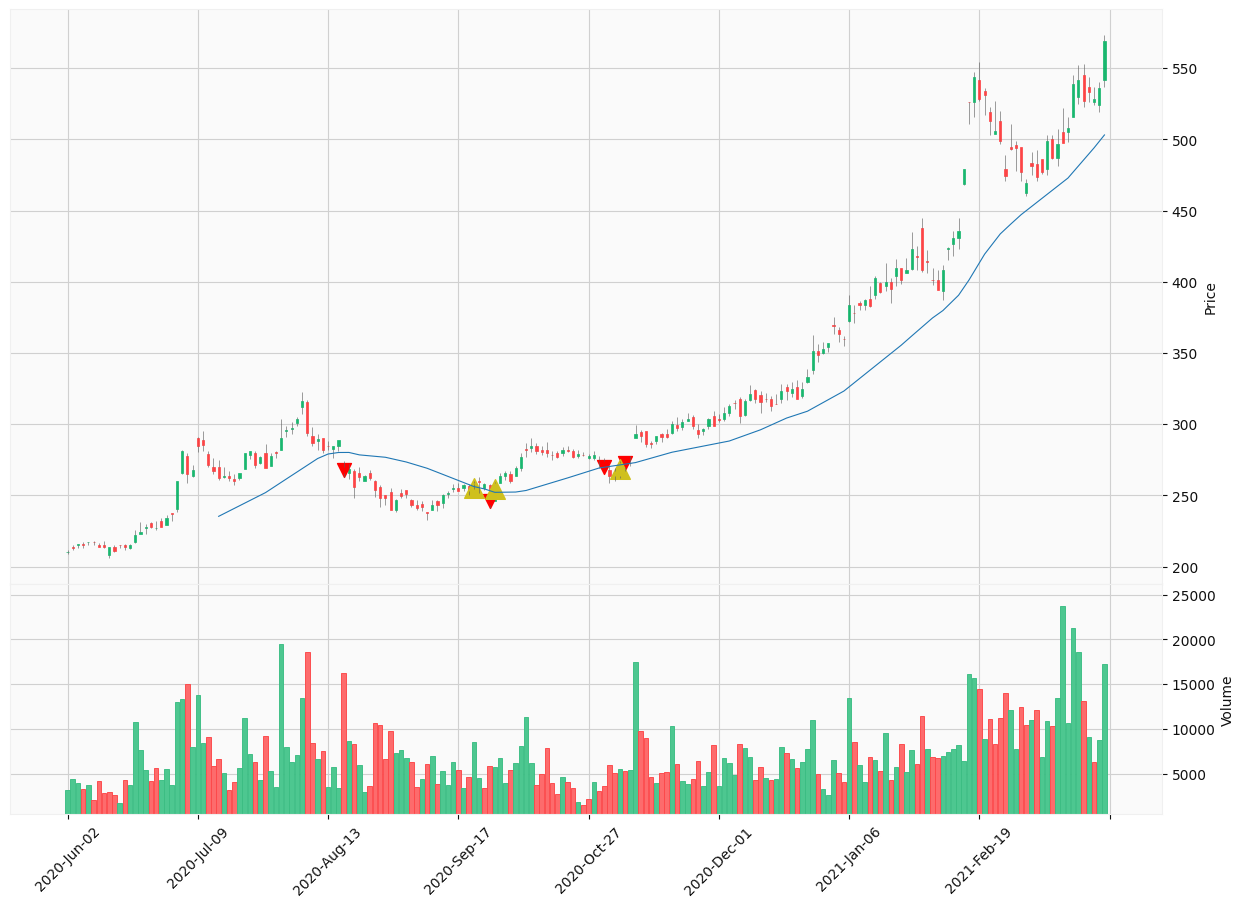

return rate: -4.0% | acc: 33.333%


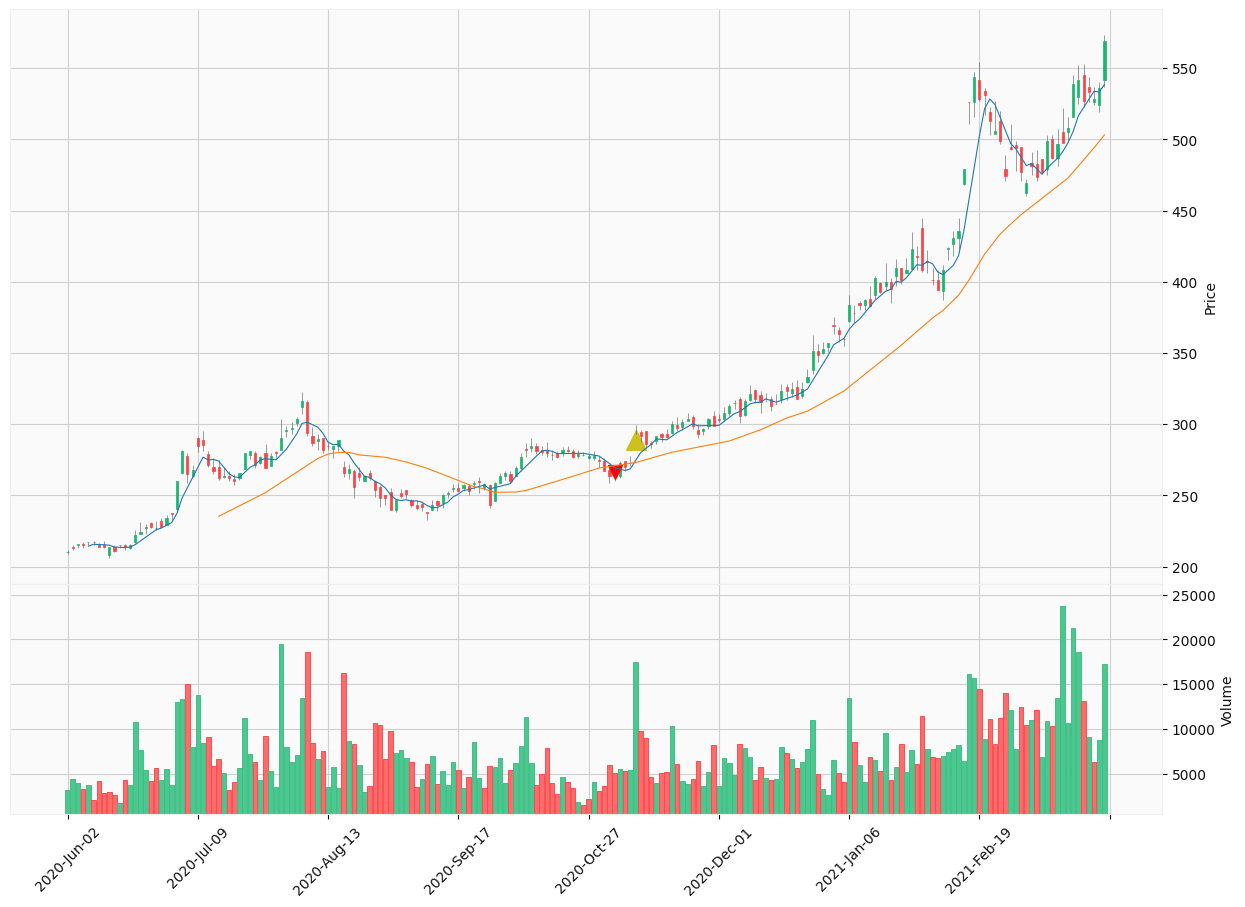

return rate: 0.0% | acc: 0.0%
../../../parse_data/data/splited/1307.csv


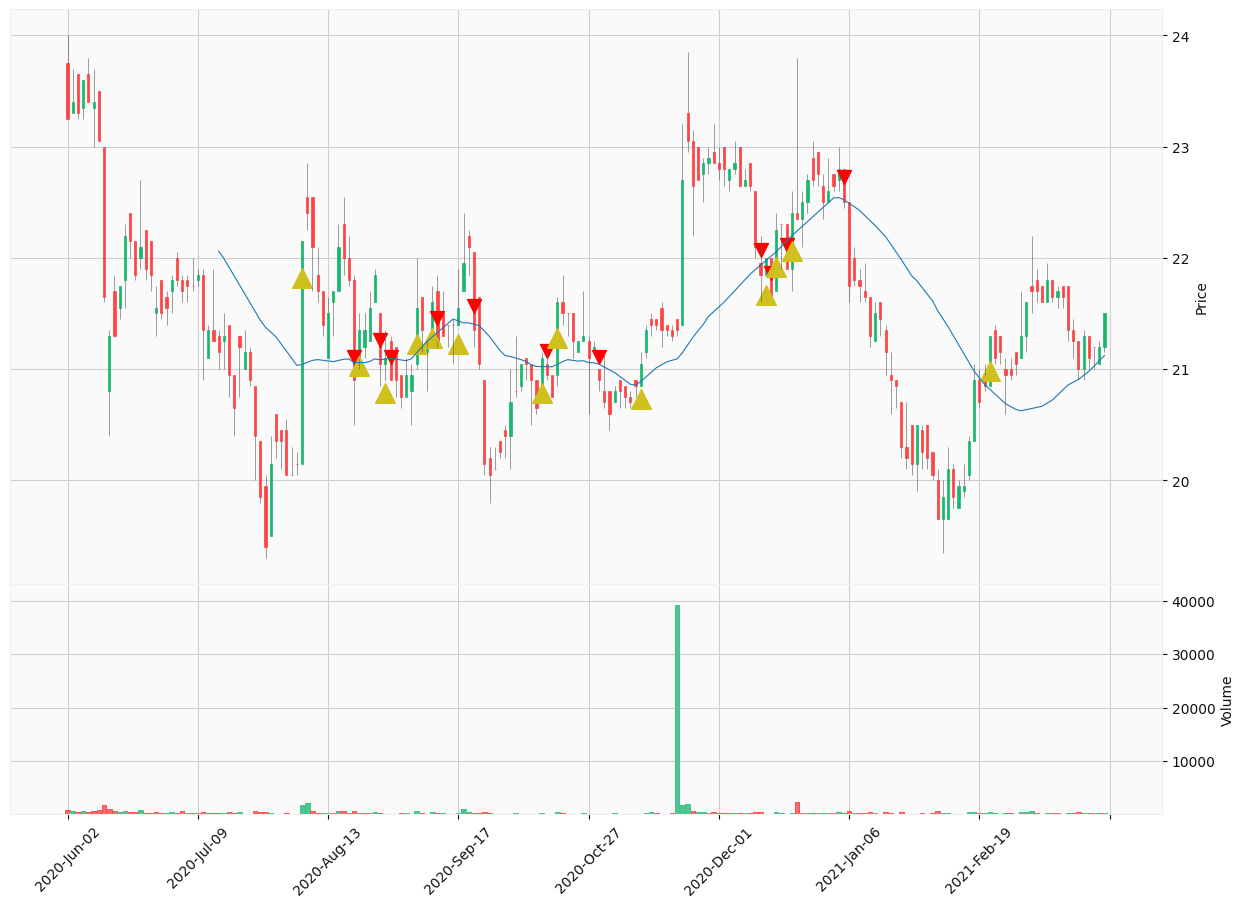

return rate: -12.8% | acc: 18.182%


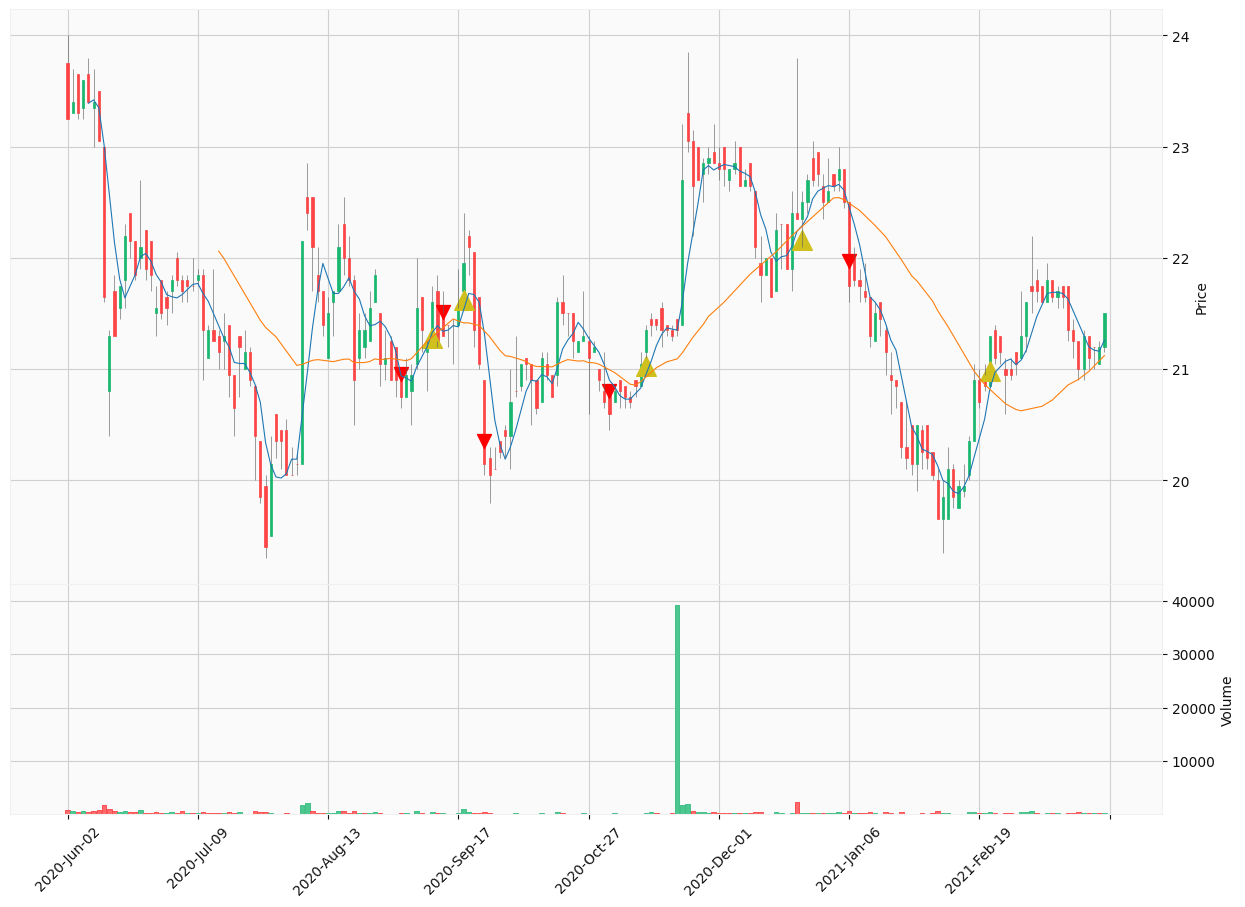

return rate: -10.2% | acc: 0.0%
../../../parse_data/data/splited/006208.csv


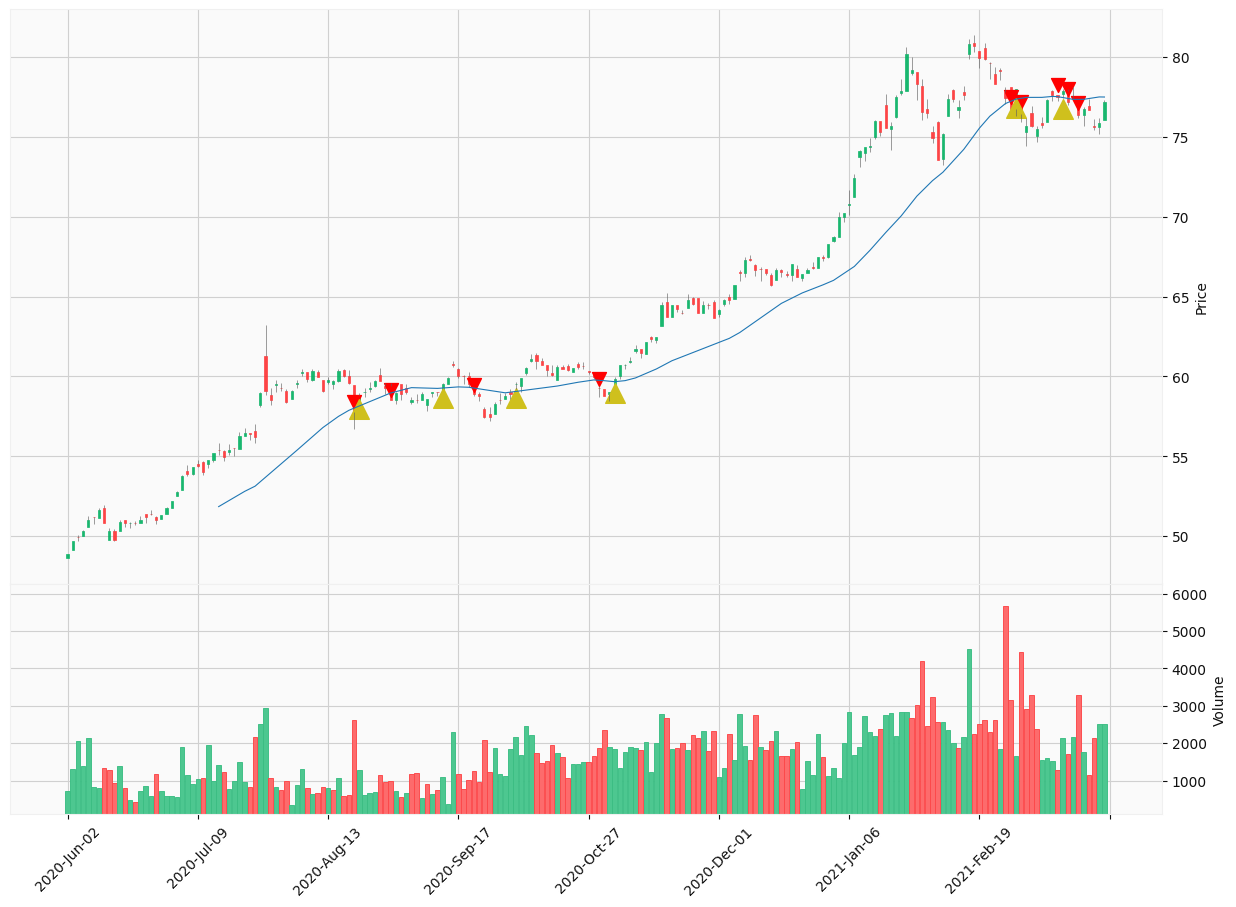

return rate: 21.9% | acc: 16.667%


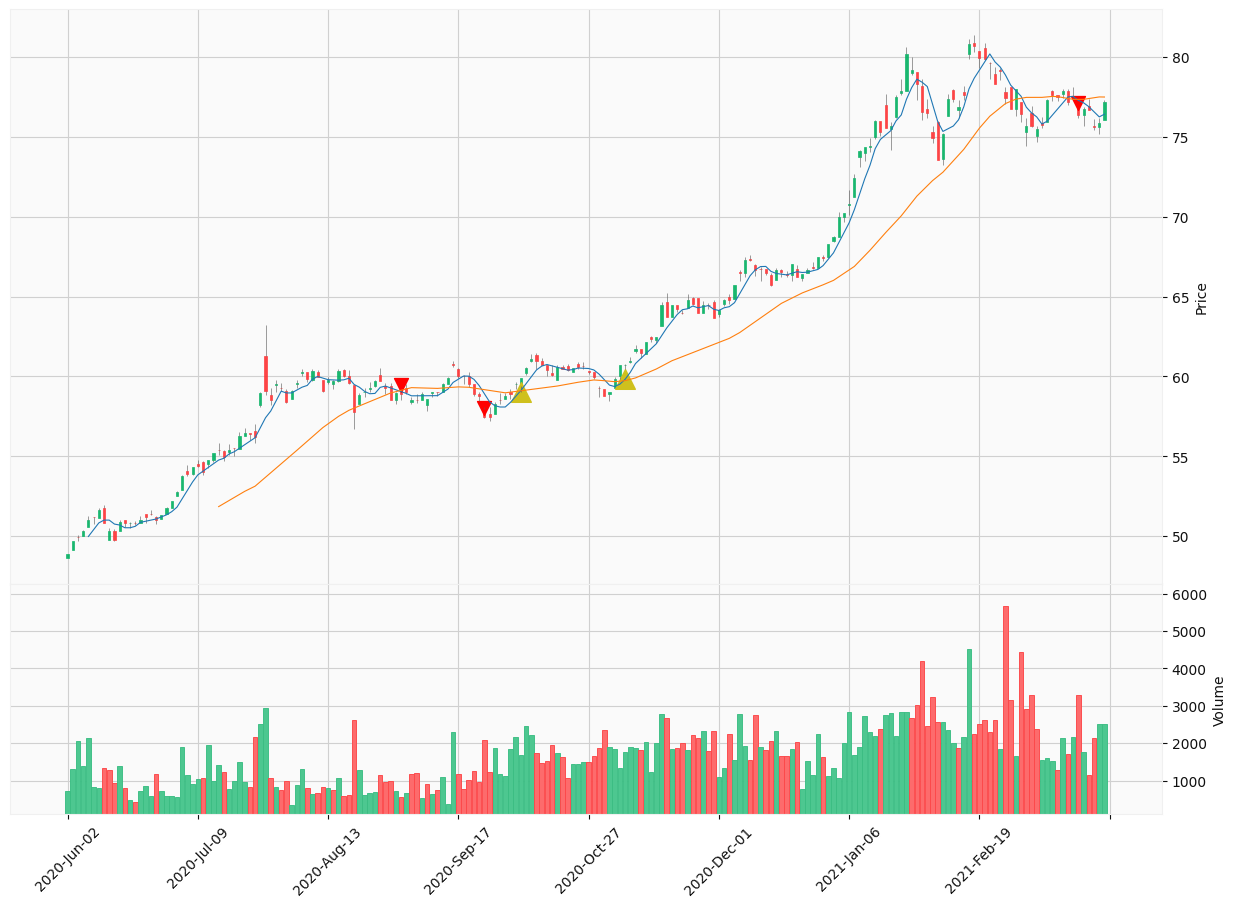

return rate: 26.6% | acc: 100.0%
../../../parse_data/data/splited/61593.csv


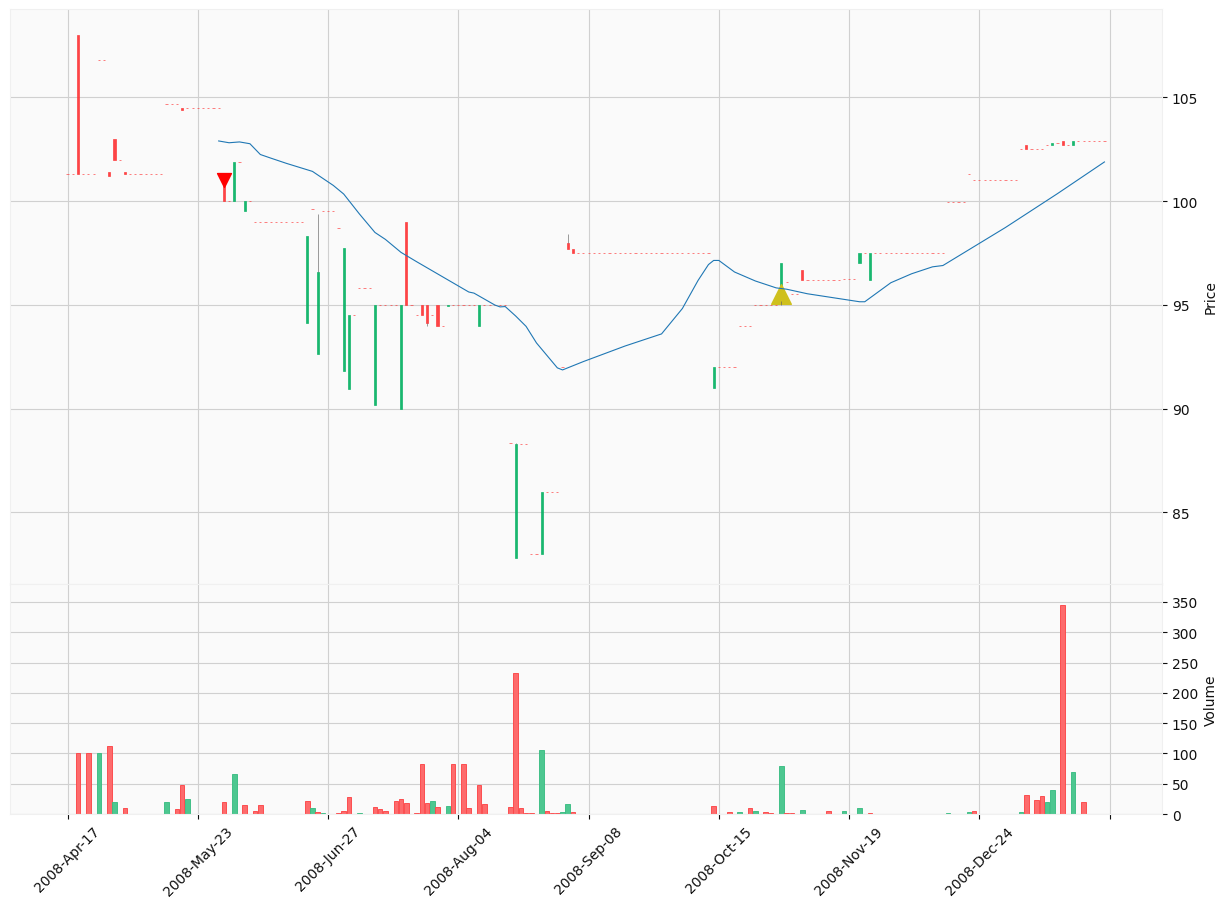

return rate: 0.0% | acc: 0.0%


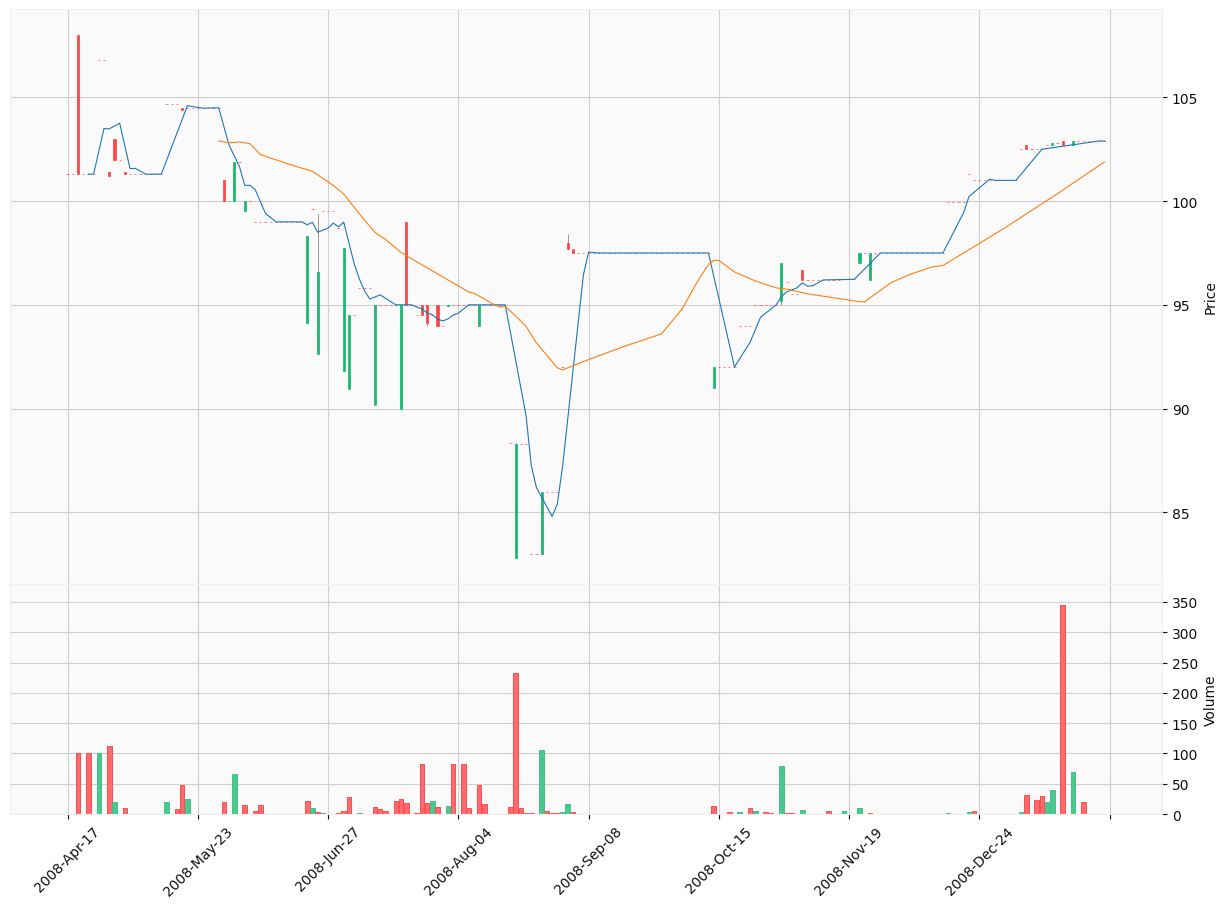

return rate: 0.0% | acc: 0.0%
../../../parse_data/data/splited/26184.csv


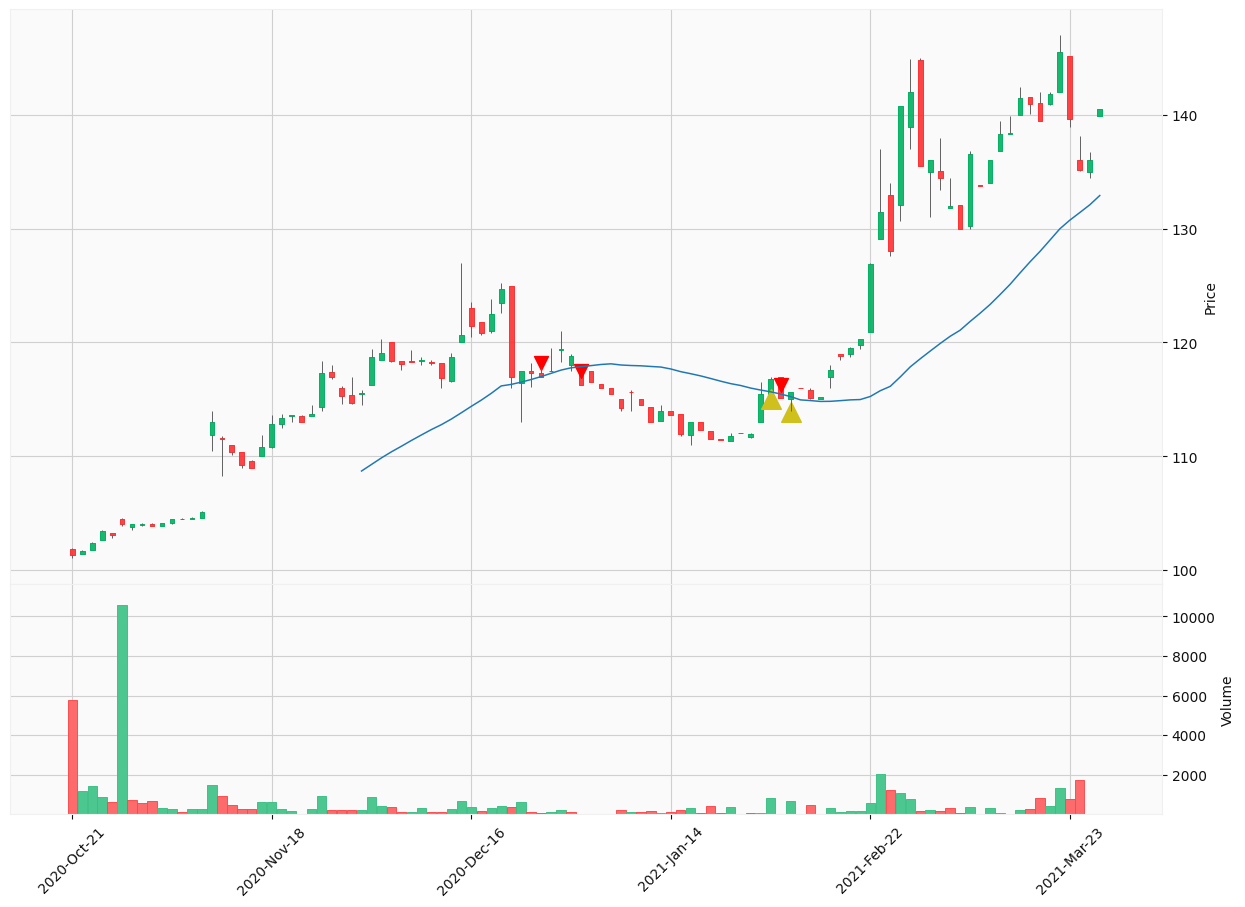

return rate: -1.5% | acc: 0.0%


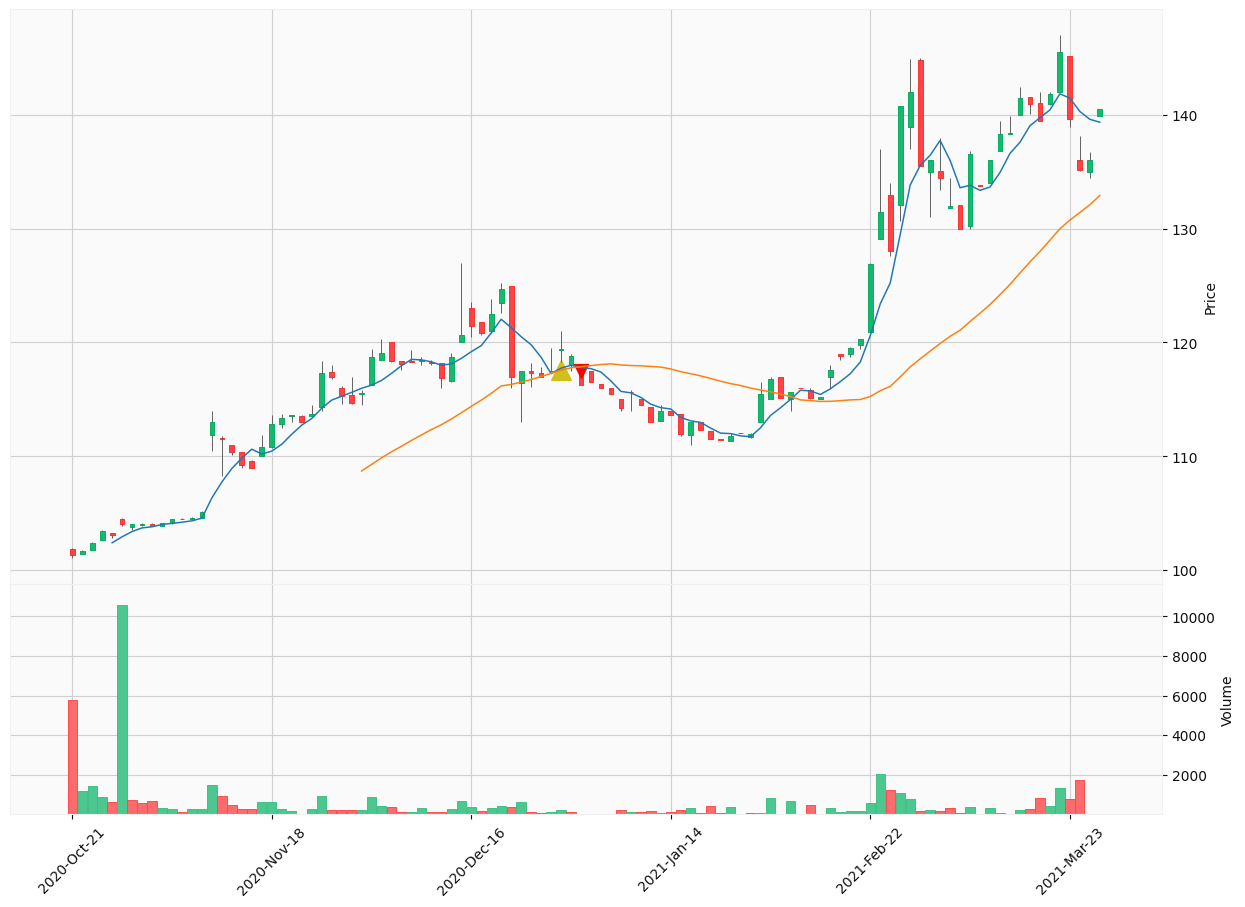

return rate: -2.6% | acc: 0.0%
return rate:
       simple_price_MA crossovers_MA
3034             -4.0%          0.0%
1307            -12.8%        -10.2%
006208           21.9%         26.6%
61593             0.0%          0.0%
26184            -1.5%         -2.6%

accuracy:
       simple_price_MA crossovers_MA
3034           33.333%          0.0%
1307           18.182%          0.0%
006208         16.667%        100.0%
61593             0.0%          0.0%
26184             0.0%          0.0%


In [98]:
random_choice_num = 5
data_directory = '../../../parse_data/data/splited/'
ticker_name_file=  '../../../parse_data/data/ticker_name.csv'

strategy_list = [simple_price_MA, crossovers_MA]
dictionary_rr = {}
dictionary_acc = {}

for data_file in file_list_with_directory(random_sample(ticker_list_file = ticker_name_file, times = random_choice_num), data_directory):
    
    slim_file_name = (data_file.split('/')[-1]).split('.')[0]

    print(data_file)
    ticker = get_dataframe(data_file, days=200)
    
    strategy_rr= []
    strategy_acc = []
    for i in range(len(strategy_list)):
        
        dw = strategy_list[i](ticker)
        return_rate, acc = backtesting(dw)
        
        return_rate = str(round(return_rate, 1))+'%'
        acc = str(round(acc, 3))+'%'
        print('return rate: {} | acc: {}'.format(return_rate, acc))
        strategy_rr.append(return_rate)
        strategy_acc.append(acc)
    

    #print(strategy_rr)
    #print(strategy_acc)
    
    dictionary_rr[slim_file_name] = strategy_rr
    dictionary_acc[slim_file_name] = strategy_acc


strategy_names = [i.__name__ for i in strategy_list]
dataframe_return_rate = pd.DataFrame.from_dict(dictionary_rr, orient='index',columns = strategy_names)
dataframe_acc = pd.DataFrame.from_dict(dictionary_acc ,orient='index',columns = strategy_names)

print('return rate:')
print(dataframe_return_rate)

print()
print('accuracy:')
print(dataframe_acc)
